# <u>Data Science Essentials</u>

## <u>Topic</u>: Target Mean Encoding

## <u>Category</u>: Feature Selection

### <u>Created By</u>: Mohammed Misbahullah Sheriff
- [LinkedIn](https://www.linkedin.com/in/mohammed-misbahullah-sheriff/)
- [GitHub](https://github.com/MisbahullahSheriff)

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from feature_engine.selection import SelectByTargetMeanPerformance

from feature_engine.wrappers import SklearnTransformerWrapper

import os

## Getting the Data

In [2]:
file_dir = "C:\Python Programs\datasets"
file_name = "titanic.csv"
file_path = os.path.join(file_dir, file_name)

titanic = (
    pd
     .read_csv(file_path)
     .drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])
     .rename(columns=str.lower)
)

print("Data Shape:", titanic.shape)
titanic.head()

Data Shape: (891, 8)


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [3]:
file_dir = "C:\Python Programs\datasets"
file_name = "car-details.csv"
file_path = os.path.join(file_dir, file_name)

cars = pd.read_csv(file_path)
print("Data Shape:", cars.shape)
cars.head()

Data Shape: (6926, 16)


,name,company,model,edition,year,owner,fuel,seller_type,transmission,km_driven,mileage_mpg,engine_cc,max_power_bhp,torque_nm,seats,selling_price
0,Maruti Swift Dzire VDI,Maruti,Swift,Dzire VDI,2014,First,Diesel,Individual,Manual,145500,55.00,1248.0,74.00,190.000000,5.0,450000
1,Skoda Rapid 1.5 TDI Ambition,Skoda,Rapid,1.5 TDI Ambition,2014,Second,Diesel,Individual,Manual,120000,49.70,1498.0,103.52,250.000000,5.0,370000
2,Honda City 2017-2020 EXi,Honda,City,2017-2020 EXi,2006,Third,Petrol,Individual,Manual,140000,41.60,1497.0,78.00,124.544455,5.0,158000
3,Hyundai i20 Sportz Diesel,Hyundai,i20,Sportz Diesel,2010,First,Diesel,Individual,Manual,127000,54.06,1396.0,90.00,219.668960,5.0,225000
4,Maruti Swift VXI BSIII,Maruti,Swift,VXI BSIII,2007,First,Petrol,Individual,Manual,120000,37.84,1298.0,88.20,112.776475,5.0,130000


In [4]:
def get_preprocessor(X):
  """

  Description:
  ------------
  This function will return an object to impute all the features of any dataset

  Parameters:
  -----------
  X: dataframe
     Any dataset to perform the imputation on

  """
  num_cols = X.select_dtypes(include="number").columns.to_list()
  obj_cols = X.select_dtypes(exclude="number").columns.to_list()

  num_imputer = SklearnTransformerWrapper(SimpleImputer(strategy="mean"), variables=num_cols)

  obj_imputer = SklearnTransformerWrapper(SimpleImputer(strategy="most_frequent"), variables=obj_cols)

  preprocessor = Pipeline(steps=[
      ("num_imputer", num_imputer),
      ("obj_imputer", obj_imputer),
  ])

  return preprocessor

## Demo 1 - Classification

In [5]:
X = titanic.drop(columns="survived")
y = titanic.survived.copy()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(712, 7) (712,)
(179, 7) (179,)


### Training the Selector

In [6]:
select = SelectByTargetMeanPerformance(
    bins=5,
    strategy="equal_frequency",
    scoring="roc_auc",
    cv=3,
    threshold=False,
    regression=False
)

selector = Pipeline(steps=[
    ("pre", get_preprocessor(X_train)),
    ("select", select)
])

selector.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('num_imputer',
                                  SklearnTransformerWrapper(transformer=SimpleImputer(),
                                                            variables=['pclass',
                                                                       'age',
                                                                       'sibsp',
                                                                       'parch',
                                                                       'fare'])),
                                 ('obj_imputer',
                                  SklearnTransformerWrapper(transformer=SimpleImputer(strategy='most_frequent'),
                                                            variables=['sex',
                                                                       'embarked']))])),
                ('select',
                 SelectByTargetMeanPerformance(strategy='equal_frequency',
                                               threshold=False))])

### Ranking the Features

In [7]:
scores = selector.named_steps["select"].feature_performance_
scores

{'pclass': 0.6631303030520251,
 'sex': 0.7703000413372233,
 'age': 0.5506418534095358,
 'sibsp': 0.5169393011858766,
 'parch': 0.5233537391071638,
 'fare': 0.6919530319027104,
 'embarked': 0.586343594590729}

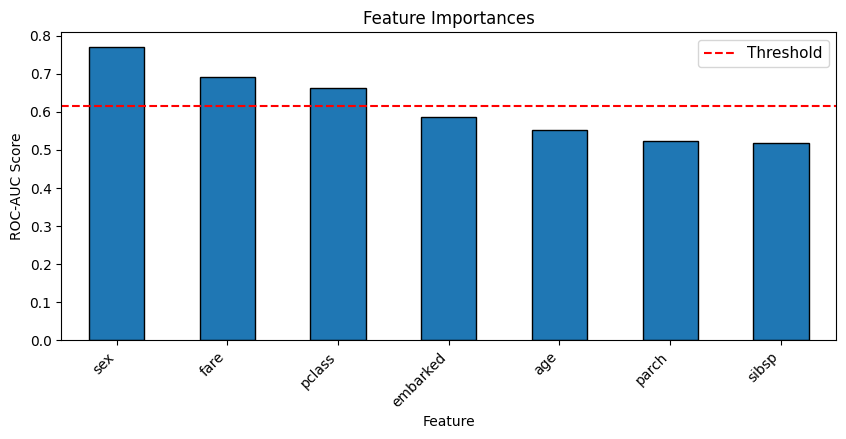

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))

(
    pd
      .Series(scores)
      .sort_values(ascending=False)
      .plot(kind="bar",
            ax=ax,
            **dict(edgecolor="black"))
)

ax.axhline(np.mean([value for value in scores.values()]),
           color="red",
           linestyle="--",
           label="Threshold")

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   ha="right")

ax.set(xlabel="Feature",
       ylabel="ROC-AUC Score",
       title="Feature Importances")

ax.legend(loc="upper right", fontsize=11)

plt.show()

### Dropping the Features

In [9]:
selector.named_steps["select"].features_to_drop_

['age', 'sibsp', 'parch', 'embarked']

In [10]:
selector.transform(X_train).head()

,pclass,sex,fare
692,3.0,male,56.4958
481,2.0,male,0.0000
527,1.0,male,221.7792
855,3.0,female,9.3500
801,2.0,female,26.2500


## Demo 2 - Regression

In [11]:
X = cars.drop(columns=["selling_price", "name", "edition", "company", "model"])
y = cars.selling_price.copy()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5540, 11) (5540,)
(1386, 11) (1386,)


### Training the Selector

In [12]:
select = SelectByTargetMeanPerformance(
    bins=5,
    strategy="equal_width",
    scoring="r2",
    cv=3,
    threshold=False,
    regression=True
)

selector = Pipeline(steps=[
    ("pre", get_preprocessor(X_train)),
    ("select", select)
])

selector.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('num_imputer',
                                  SklearnTransformerWrapper(transformer=SimpleImputer(),
                                                            variables=['year',
                                                                       'km_driven',
                                                                       'mileage_mpg',
                                                                       'engine_cc',
                                                                       'max_power_bhp',
                                                                       'torque_nm',
                                                                       'seats'])),
                                 ('obj_imputer',
                                  SklearnTransformerWrapper(transformer=SimpleImputer(strategy='most_frequent'),
                                                            variables=['owner',
                                                                       'fuel',
                                                                       'seller_type',
                                                                       'transmission']))])),
                ('select',
                 SelectByTargetMeanPerformance(regression=True, scoring='r2',
                                               threshold=False))])

### Ranking the Features

In [13]:
scores = selector.named_steps["select"].feature_performance_
scores

{'year': 0.15362287591598742,
 'owner': 0.10039692138766525,
 'fuel': 0.06783713791926083,
 'seller_type': 0.0760277859810848,
 'transmission': 0.232366789217481,
 'km_driven': 0.004158630487220242,
 'mileage_mpg': 0.041358968054251356,
 'engine_cc': 0.2082304276735657,
 'max_power_bhp': 0.4549500031741052,
 'torque_nm': 0.23878514743071055,
 'seats': 0.04215541878209624}

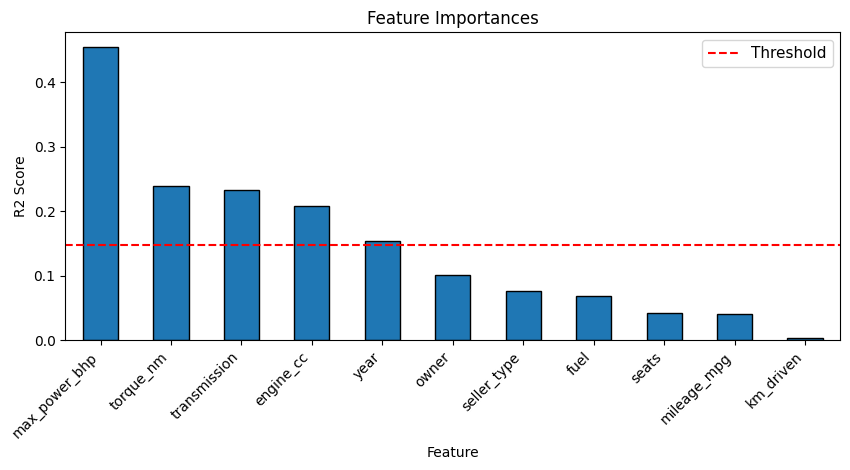

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))

(
    pd
      .Series(scores)
      .sort_values(ascending=False)
      .plot(kind="bar",
            ax=ax,
            **dict(edgecolor="black"))
)

ax.axhline(np.mean([value for value in scores.values()]),
           color="red",
           linestyle="--",
           label="Threshold")

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   ha="right")

ax.set(xlabel="Feature",
       ylabel="R2 Score",
       title="Feature Importances")

ax.legend(loc="upper right", fontsize=11)

plt.show()

### Dropping the Features

In [15]:
selector.named_steps["select"].features_to_drop_

['owner', 'fuel', 'seller_type', 'km_driven', 'mileage_mpg', 'seats']

In [16]:
selector.transform(X_train).head()

,year,transmission,engine_cc,max_power_bhp,torque_nm
4855,2018.0,Manual,1498.000000,98.960000,205.000000
3143,2010.0,Manual,1436.969449,88.033448,176.296696
4275,2011.0,Manual,1396.000000,90.000000,219.668960
2288,2009.0,Manual,1248.000000,73.900000,190.000000
3914,2003.0,Manual,1493.000000,82.000000,187.000000
